# Topic1. A* path planning

If you got the point for problem definition in AIMA textbook, please execute and run the block until section 1-4

## 1-1. Import python package

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
import numpy as np
from collections import defaultdict, deque, Counter
from itertools import combinations

## 1-2. Problem abstract & State-space tree node & queue

In [3]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    Subclasses can add other keywords besides initial and goal.
    The default heuristic is 0 and the default step cost is 1 for all states."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
    
    
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0
    
    def __str__(self):
        return '{}({}, {})'.format(type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=float('inf')) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=float('inf')) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    return [] if node.parent is None else path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state]

In [4]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

## 1-3. Search methods

In [135]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    frontier = FIFOQueue([Node(problem.initial)])
    reached = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure

In [136]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first; make `reached` global."
    global reached # <<<<<<<<<<< Only change here
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while len(frontier) != 0:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if (s not in reached) or (child.path_cost < reached[s].path_cost):
                reached[s] = child
                frontier.add(child)
    return failure

# It is also popular to Dijkstra's algorithm
def uniform_cost_search(problem):
    "Search nodes with minimum  path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))


def weighted_astar_search(problem, weight=1.4, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + weight * h(node))

def greedy_best_first_search(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

## 1-4. Grid Problem

In [137]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""
    
    def __init__(self, initial=(1.0, 1.0), goal=(1.7, 2.8), obstacles=(),
                 grid_size=0.1, veh_size=(0.2, 0.2), MAX_X=1.8, MAX_Y=3.0, **kwds):
        
        Problem.__init__(self, initial=initial, goal=goal, obstacles=set(obstacles) - {initial, goal},
                         grid_size=grid_size, veh_size=veh_size, MAX_X=MAX_X, MAX_Y=MAX_Y, **kwds)
        
        self.directions = [(-1, -1), (0, -1), (1, -1),
                        (-1, 0),           (1,  0),
                        (-1, +1), (0, +1), (1, +1)]
        
        self.gridmap = set()
        self.to_grid = lambda state: (int(state[0]*10/self.grid_size/10), int(state[1]*10/self.grid_size/10))
        self.generate_gridmap()
        
    def generate_gridmap(self):
        for p in self.obstacles:
            self.gridmap.add(self.to_grid(p))
            
    def step_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        result_grid_loc = self.to_grid(state)
        return action if action not in self.gridmap else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
#         x, y = (int(state[0] / self.grid_size), int(state[1] / self.grid_size))
        x, y = state
        action_list = []
        for (dx, dy) in self.directions:
            p = (round(x + dx*self.grid_size, 2), round(y + dy*self.grid_size, 2))
            if self.to_grid(p) not in self.gridmap:
                action_list.append(p)
        return action_list
#         return [(x + dx, y + dy) for (dx, dy) in self.directions
#                 if (x + dx, y + dy) not in self.gridmap]
    
    def is_goal(self, state):
        return self.to_grid(state) == self.to_grid(self.goal)


In [138]:
gp1 = GridProblem(initial=(0.5, 2.7), obstacles=fixed_map())
print ('real:{}, grid:{}'. format(gp1.initial, gp1.to_grid(gp1.initial)))

real:(0.5, 2.7), grid:(5, 27)


## Function for creating obstacle

In [139]:
# The following can be used to create obstacles:
def straight_line_distance(point1, point2):
    "Straight-line distance between two 2D points."
    return abs(complex(*point1) - complex(*point2))
    

def random_lines(X=range(15), Y=range(6), N=150, lengths=range(6, 12), dirs=((0, 1), (1, 0))):
    """Yield the cells in N random lines of the given lengths."""
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(dirs)
        for obj_line in line(x, y, dx, dy, random.choice(lengths)):
            yield obj_line            
            
def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in np.arange(0, length, 0.01)}

def add_block(x, y, len_x, len_y):
    for obj_line in line(x, y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y+len_y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y, 0, 1, len_y):
        yield obj_line
    for obj_line in line(x+len_x, y, 0, 1, len_y):
        yield obj_line

def fixed_map():
    for obj_line in add_block(x=0, y=0, len_x=1.8, len_y=3.0):
        yield obj_line

    for obj_line in add_block(x=0.8, y=1.4, len_x=0.15, len_y=0.2):
        yield obj_line

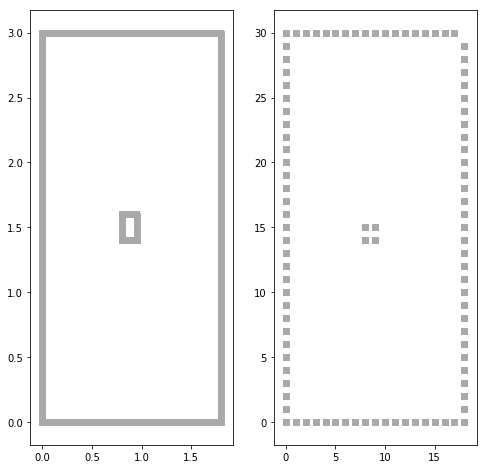

In [140]:
gp1 = GridProblem(initial=(0.5, 0.5), obstacles=fixed_map())
plt.figure(figsize=(8, 8))
plt.subplot(121)
obs_list = list(gp1.obstacles)
for point in obs_list:
    plt.scatter(point[0], point[1], marker='s', color='darkgrey')

plt.subplot(122)       
obs_list = list(gp1.gridmap)
for point in obs_list:
    plt.scatter(point[0], point[1], marker='s', color='darkgrey')
plt.scatter(point[0], point[1], marker='s', color='darkgrey')
plt.show()

In [141]:
def plot_grid_problem(grid_problem, solution, reached=(), title='Search'):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    plt.figure(figsize=(15, 6))
    plt.axis('off'); plt.axis('equal')
    
    # plot initial position and goal
    start = grid_problem.to_grid(grid_problem.initial)
    goal = grid_problem.to_grid(grid_problem.goal)
    plt.scatter(start[0], start[1], 11**2, marker='D', c='green')
    plt.scatter(goal[0], goal[1], 10**2, marker='D', c='red')
    plt.legend(['current_loc', 'goal_loc'])
    
    # plot obstacle
#     obs_list = list(grid_problem.obstacles)
    obs_list = list(grid_problem.gridmap)
    for point in obs_list:
        plt.scatter(point[0], point[1], marker='s', color='darkgrey')
    
    
    # plot reached path
    reached_list = list(reached)
    for point in reached_list:
        grid_p = grid_problem.to_grid(point)
        plt.scatter(grid_p[0], grid_p[1], 1**2, marker='.', c='blue')
    
    # plot solution path
    traj_list = list(path_states(solution))
    for point in traj_list:
        grid_p = grid_problem.to_grid(point)
        plt.scatter(grid_p[0], grid_p[1], marker='s', c='black')

    plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def transpose(matrix): return list(zip(*matrix))

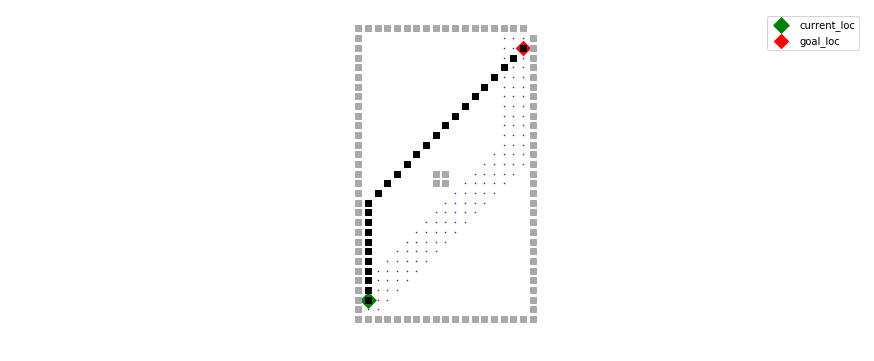

           Search search: 3.3 path cost, 114 states reached


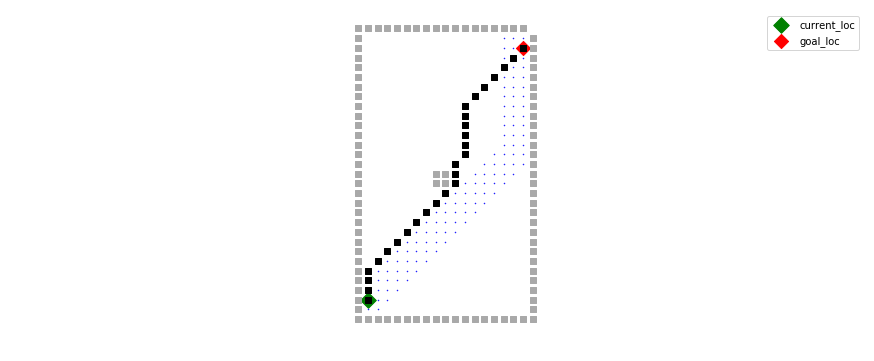

           Search search: 3.3 path cost, 114 states reached


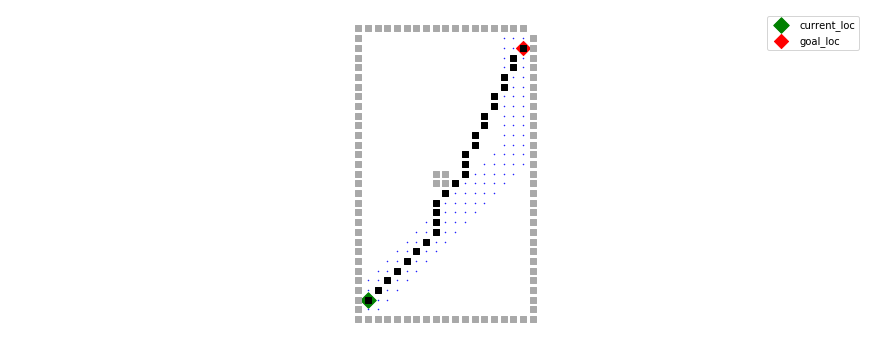

           Search search: 3.3 path cost, 114 states reached


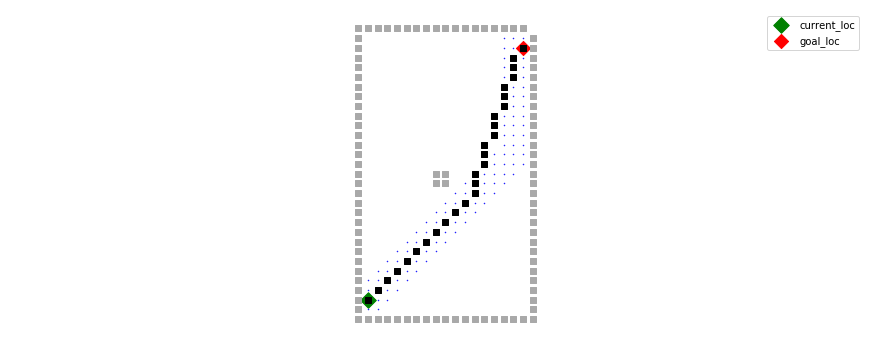

           Search search: 3.3 path cost, 114 states reached


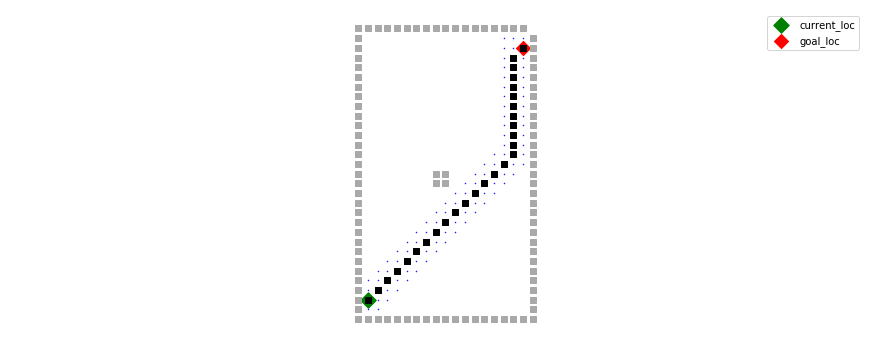

           Search search: 3.3 path cost, 114 states reached


In [142]:
# Test algorithm
gp1 = GridProblem(initial=(0.15, 0.2), obstacles=fixed_map())
sol1 = breadth_first_search(gp1)
sol2 = uniform_cost_search(gp1)
sol3 = astar_search(gp1)
sol4 = weighted_astar_search(gp1)
sol5 = greedy_best_first_search(gp1)

plot_grid_problem(gp1, sol1, reached)
plot_grid_problem(gp1, sol2, reached)
plot_grid_problem(gp1, sol3, reached)
plot_grid_problem(gp1, sol4, reached)
plot_grid_problem(gp1, sol5, reached)

<font color="red">
    
# ROS start here
</font>

In [9]:
import os
sys.path.insert(0, '/opt/ros/kinetic/lib/python2.7/dist-packages')
sys.path.insert(0, 'catkin_ws/devel/lib/python2.7/dist-packages')

os.environ["ROS_MASTER_URI"] = "http://192.168.50.19:11311"
os.system('source catkin/devel/setup.sh')

import rospy
import tf
from nav_msgs.msg import Odometry, Path
from geometry_msgs.msg import PoseStamped
from duckietown_msgs.msg import Pose2DStamped

# from eric point

In [10]:
rospy.init_node("path_planning_node", anonymous = False)
path_pub = rospy.Publisher('/planning_path', Path, queue_size=10)

In [11]:
loc_msg = rospy.wait_for_message("/nctuece/absolute_from_relative_position/bot_global_poses_for_car", \
                                     topic_type=Pose2DStamped,
                                     timeout=5)
initial_point = (int(loc_msg.x*10), int(loc_msg.y*10))
print(initial_point)
goal_point = (initial_point[0], initial_point[1] + 25)
print(goal_point)

(13, 2)
(13, 27)


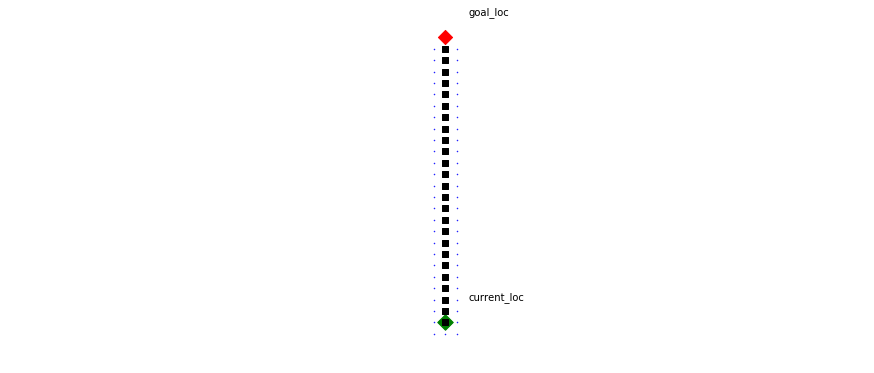

           Search search: 24.0 path cost, 78 states reached


In [12]:
gridproblem1 = GridProblem(initial=initial_point, goal=goal_point, obstacles=random_lines(N=0))
solution = astar_search(gridproblem1)
plot_grid_problem(gridproblem1, solution, reached)

In [13]:
path = Path()
path.header.frame_id = 'map'
path.header.stamp = rospy.Time.now()

traj_list = [(p[0] / 10.0, p[1] / 10.0) for p in list(path_states(solution))]
print traj_list
for i in range(len(traj_list)-1) :
    p = PoseStamped()
    p.header.frame_id = 'map'
    p.header.stamp = rospy.Time.now()
    p.pose.position.x = traj_list[i][0]
    p.pose.position.y = traj_list[i][1]
    
    head_angle = math.atan2(traj_list[i+1][1] - traj_list[i][1],
                            traj_list[i+1][0] - traj_list[i][0])
#     print(p.pose.position.x, p.pose.position.y, head_angle*180.0/math.pi)
    
    (p.pose.orientation.x, p.pose.orientation.y, p.pose.orientation.z, p.pose.orientation.w) = tf.transformations.quaternion_from_euler(0, 0, math.pi)
    path.poses = path.poses + [p]



[(1.3, 0.2), (1.3, 0.3), (1.3, 0.4), (1.3, 0.5), (1.3, 0.6), (1.3, 0.7), (1.3, 0.8), (1.3, 0.9), (1.3, 1.0), (1.3, 1.1), (1.3, 1.2), (1.3, 1.3), (1.3, 1.4), (1.3, 1.5), (1.3, 1.6), (1.3, 1.7), (1.3, 1.8), (1.3, 1.9), (1.3, 2.0), (1.3, 2.1), (1.3, 2.2), (1.3, 2.3), (1.3, 2.4), (1.3, 2.5), (1.3, 2.6)]


In [14]:
for i in range(10):
    path_pub.publish(path)